# Stochastic Simulation -- Asignment 1
## Walter Vianen -- 11811293
## Daan van Ingen -- 10345078

In [1]:
# Import packages
from matplotlib import pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from numba import jit
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import math
import itertools
import random
import sys

## Visual Representation Mandelbrot Set
The following just contains the functions needed to plot the Mandelbrot set for different zoom. Some parameters for this include `MAXITER` which is the maximum number of iterations calculated in the Mandelbrot sequence, `CMAP` which a colormap used in the image and `DPI` which relates to the number of pixels in the figures (increasing this will increase resolution). More importantly, the function `mandelbrot` computes the Mandelbrot sequence for a given number `c` and returns the number of iterations it takes to first exceed a certain threshold or returns zero in the case it does not diverge within `MAXITER` iterations. 

In [2]:
MAXITER = 300
CMAP = 'gnuplot2'
DPI = 300

In [2]:
# Functions needed to compute the Mandelbrot set (adapted from https://gist.github.com/jfpuget/60e07a82dece69b011bb)
@jit
def mandelbrot(c, maxiter):
    z = c
    for n in range(maxiter):
        if abs(z) > 3:
            return n
        z = z*z + c
    return 0

@jit
def mandelbrot_set(xmin, xmax, ymin, ymax, width, height, maxiter):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    n3 = np.empty((width, height))
    for i in range(width):
        for j in range(height):
            n3[i,j] = mandelbrot(r1[i] + 1j*r2[j], maxiter)
    return (r1, r2, n3)

def mandelbrot_image(xmin, xmax, ymin, ymax, width, height, maxiter, cmap):
    img_width = DPI * width
    img_height = DPI * height
    x,y,z = mandelbrot_set(xmin ,xmax, ymin, ymax, img_width, img_height, maxiter)
    
    fig, ax = plt.subplots(figsize=(width, height), dpi=DPI)
    ticks = np.arange(0, img_width+1, int(img_width/4))
    x_ticks = xmin + (xmax-xmin)*ticks/img_width
    plt.xticks(ticks, x_ticks)
    y_ticks = ymin + (ymax-ymin)*ticks/img_width
    plt.yticks(ticks, y_ticks)
    
    norm = colors.PowerNorm(0.5)
    ax.imshow(z.T, cmap=cmap, origin='lower', norm=norm)
    plt.show()

In [ ]:
# Plot Mandelbrot Set (with different zoom)
# mandelbrot_image(-2, 1, -1.5, 1.5, 5, 5, maxiter = MAXITER, cmap=CMAP)

# mandelbrot_image(-1.5, 0, -0.75, 0.75, 5, 5, maxiter = MAXITER, cmap=CMAP)

# mandelbrot_image(-1.0, -0.5, 0, 0.5, 5, 5, maxiter = MAXITER, cmap=CMAP)

# mandelbrot_image(-0.8, -0.7, 0.2, 0.3, 5, 5, maxiter = MAXITER, cmap=CMAP)

# mandelbrot_image(-0.76, -0.70, 0.20, 0.26, 5, 5, maxiter = MAXITER, cmap=CMAP)

# mandelbrot_image(-0.75, -0.73, 0.20, 0.22, 5, 5, maxiter = MAXITER, cmap=CMAP)

## Hit-and-Miss Functions
Here the functions for the random, latin hypercube and orthogonal sampling methods are defined respectively. In the cell after the declaration of the respective functions a setup is given such that it can be run once to get a feel of the output. 

In [3]:
@jit
def random_hit_miss(S, MAXITER, xmin, xmax, ymin, ymax): 
    hits = 0
    for s in range(0, S): 
        x = random.uniform(xmin, xmax)
        y = random.uniform(ymin, ymax)
        c = x + 1j*y
        if(mandelbrot(c, MAXITER) == 0): 
            hits += 1
    estimated_area = (hits / S) * (abs(xmin - xmax) * abs(ymin - ymax))
    return estimated_area

In [6]:
S, MAXITER = 100000, 300
xmin, xmax, ymin, ymax = -2, 1, -1.5, 1.5
print(random_hit_miss(S, MAXITER, xmin, xmax, ymin, ymax))

1.52253


In [4]:
@jit
def LHS_hit_miss(S, MAXITER, xmin, xmax, ymin, ymax):
    """
    Representation of samples is as follows: 
    The index of samples refers to which x-value the point will get, hence the column in the grid.
    The value at samples[index] refers to which y-value the point wil get, hence the row in the grid.
    Samples is a permutation of the numbers 0 through S-1. 
    This automatically enforces the LHS constraints by design.    
    """
    samples = np.arange(0, S)
    random.shuffle(samples)
    hits = 0
    for s in range(0, S): 
        x = xmin + s/S * abs(xmin-xmax)
        y = ymin + samples[s]/S * abs(ymin-ymax)
        c = x + 1j*y
        if(mandelbrot(c, MAXITER) == 0): 
            hits += 1
    estimated_area = (hits / S) * (abs(xmin - xmax) * abs(ymin - ymax))
    return estimated_area

In [8]:
S, MAXITER = 100000, 300
xmin, xmax, ymin, ymax = -2, 1, -1.5, 1.5
LHS_hit_miss(S, MAXITER, xmin, xmax, ymin, ymax)

1.51776

In [39]:
@jit
def ortho_hit_miss(S, MAXITER, xmin, xmax, ymin, ymax, splits):
    """
    Here we want to construct true_samples in the same representation as for the LHS sampling.
    The extra constraint is that subcells need to have the same sampling density
    """
    
    if(S % splits**2 != 0): 
        print("Please make sure S is divisible by splits^2.")
        return 0
    
    xsamples = np.arange(1, S+1)  #keeps track of all columns that have been chosen
    ysamples = np.arange(1, S+1)  #keeps track of all rows that have been chosen
    true_samples = np.zeros((S))  #to be filled with the final sampling
    cell_range = S / splits  #the amount of rows (or columns) in a subcells
    for i in range(0, splits):  #loop over all subcells
        for j in range(0, splits): 
            xcandidates = []
            ycandidates = []
            #Copy the columns and rows that have not been picked yet in this cell to be candidates
            for x in range(int(i*cell_range), int((i+1)*cell_range)): 
                if xsamples[x] != 0: 
                    xcandidates.append(xsamples[x])
            for y in range(int(j*cell_range), int((j+1)*cell_range)): 
                if ysamples[y] != 0: 
                    ycandidates.append(ysamples[y])  
            #Shuffle the candidates
            random.shuffle(xcandidates)
            random.shuffle(ycandidates)
            #Pick the first S/splits^2 columns and rows to construct the sampling for this cell
            for s in range(0, int(S/(splits*splits))): 
                x = xcandidates[s] - 1
                y = ycandidates[s] - 1
                true_samples[x] = y
                xsamples[x] = 0  #And note down which rows and columns have been picked
                ysamples[y] = 0

    #Perform the actual hit-and-miss algorithm with the constructed sampling
    hits = 0
    for s in range(0, S): 
        x = xmin + s/S * abs(xmin-xmax)
        y = ymin + true_samples[s]/S * abs(ymin-ymax)
        c = x + 1j*y
        if(mandelbrot(c, MAXITER) == 0): 
            hits += 1
    estimated_area = (hits / S) * (abs(xmin - xmax) * abs(ymin - ymax))
    return estimated_area

In [36]:
S, MAXITER = 10000, 300
SPLITS = 20  #The amount of cells in x- and y-direction. In total we'll have SPLITS^2 subcells.
xmin, xmax, ymin, ymax = -2, 1, -1.5, 1.5
ortho_hit_miss(S, MAXITER, xmin, xmax, ymin, ymax, SPLITS)

1.5354

## Error Comparison -- Iterations vs. Shots
Analysis of the error caused by the limited number of iterations in the Mandelbrot sequence and the number of shots taken in the hit-and-miss algorithm. This is done for the random sampling method only. 

In [6]:
# Compare errors caused by the finiteness of the number of iterations and the number of shots
R = 100  #Number of runs
maxiters = [100, 200, 300, 400, 500]  #Maximum number of iterations that will be tested
maxp = 6  #Maximum power of 10 for the number of shots
S = []
for p in range(3,maxp+1):
    S.append(10**p)
    if(p < maxp): 
        S.append(2*10**p)
        S.append(5*10**p)
xmin, xmax, ymin, ymax = -2, 1, -1.5, 1.5
random_estimates = np.zeros((R, len(S), len(maxiters)))
s_index, i_index = 0, 0
for MAXITER in tqdm(maxiters):
    s_index = 0
    for s in S: 
        for r in range(0, R): 
            random_estimates[r, s_index, i_index] = random_hit_miss(s, MAXITER, xmin, xmax, ymin, ymax)
        s_index += 1
    i_index += 1

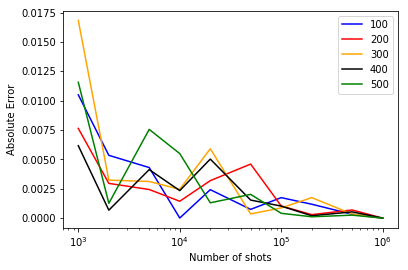

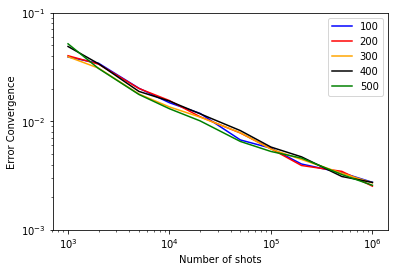

In [15]:
random_means = np.zeros((len(S), len(maxiters)))
random_stds = np.zeros((len(S), len(maxiters)))
for i in range(0, len(maxiters)): 
    for s in range(0, len(S)): 
        random_means[s, i] = np.mean(random_estimates[:, s, i])
        random_stds[s, i] = np.std(random_estimates[:, s, i], ddof=1)

differences = np.zeros((len(S), len(maxiters)))
half_ci = np.zeros((len(S), len(maxiters)))
for i in range(0, len(maxiters)): 
    for s in range(0, len(S)):
        differences[s, i] = abs(random_means[s, i] - random_means[len(S)-1, i])
        half_ci[s, i] = 1.9842 / np.sqrt(R) * (random_stds[s, i] + random_stds[len(S)-1, i])

colors = ['blue', 'red', 'orange', 'black', 'green']
for i in range(0, len(maxiters)): 
    label = (i+1)*100
    plt.plot(S, differences[:, i], color=colors[i], label='%d'%label)
    #plt.fill_between(S, differences[:,i]-half_ci[:,i], differences[:,i]+half_ci[:,i], color=colors[i], alpha=0.15, linewidth=0)

plt.ylabel('Absolute Error')
plt.xlabel('Number of shots')
plt.xscale('log')
plt.legend()
plt.savefig('results/error_different_iters.png', bbox_inches='tight')
plt.show()


for i in range(0, len(maxiters)):
    label = (i+1)*100
    plt.plot(S, 2*half_ci[:, i], color=colors[i], label='%d'%label)
    
plt.ylabel('Error Convergence')
plt.xlabel('Number of shots')
plt.ylim(10**(-3), 10**(-1))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.savefig('results/convergence_different_iters.png', bbox_inches='tight')
plt.show()

## Comparison Sampling Methods
Comparison of the performance of the different sampling methods (random, latin hypercube and orthogonal). The most important measure here is the convergence, which is proportional to twice the corrected sample standard deviation (thus also a direct measure for the uncertainty in the mean value).  

In [85]:
R = 5  #Number of runs
MAXITER = 300  #Number of iterations in Mandelbrot sequence
S = [] #Number of shots taken
maxp = 6
for p in range(4,maxp+1):
    S.append(10**p)
    if(p < maxp): 
        S.append(2*10**p)
        S.append(5*10**p)
SPLITS = 20  #Splits^2 is the number of subcells in orthogonal sampling
xmin, xmax, ymin, ymax = -2, 1, -1.5, 1.5
random_estimates = np.zeros((R, len(S)))
LHS_estimates = np.zeros((R, len(S)))
ortho_estimates = np.zeros((R, len(S)))
s_index = 0
for s in tqdm(S): 
    for r in range(0, R): 
        random_estimates[r, s_index] = random_hit_miss(s, MAXITER, xmin, xmax, ymin, ymax)
        LHS_estimates[r, s_index] = LHS_hit_miss(s, MAXITER, xmin, xmax, ymin, ymax)
        ortho_estimates[r, s_index] = ortho_hit_miss(s, MAXITER, xmin, xmax, ymin, ymax, SPLITS)
    s_index += 1

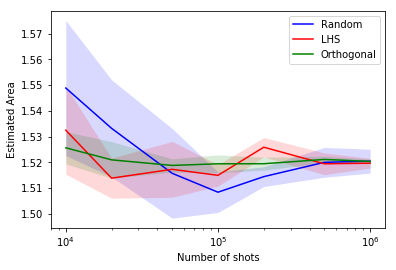

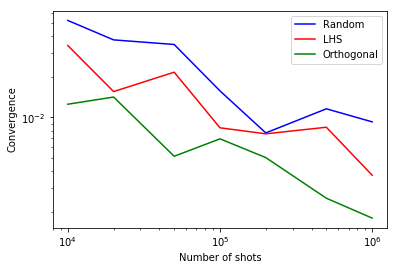

In [86]:
random_means = np.zeros((len(S)))
LHS_means = np.zeros((len(S)))
ortho_means = np.zeros((len(S)))
random_convergence = np.zeros((len(S)))
LHS_convergence = np.zeros((len(S)))
ortho_convergence = np.zeros((len(S)))

for s in range(0, len(S)): 
    random_means[s] = np.mean(random_estimates[:, s])
    LHS_means[s] = np.mean(LHS_estimates[:, s])
    ortho_means[s] = np.mean(ortho_estimates[:, s])
    random_convergence[s] = 2 * 1.9842 * np.std(random_estimates[:, s], ddof=1) / np.sqrt(R)
    LHS_convergence[s] = 2 * 1.9842 * np.std(LHS_estimates[:, s], ddof=1) / np.sqrt(R)
    ortho_convergence[s] = 2 * 1.9842 * np.std(ortho_estimates[:, s], ddof=1) / np.sqrt(R)

colors = ['blue', 'red', 'green']
plt.plot(S, random_means, color=colors[0], label='Random')
plt.plot(S, LHS_means, color=colors[1], label='LHS')
plt.plot(S, ortho_means, color=colors[2], label='Orthogonal')
plt.fill_between(S, random_means-1/2*random_convergence, random_means+1/2*random_convergence, color=colors[0], alpha=0.15, linewidth=0)
plt.fill_between(S, LHS_means-1/2*LHS_convergence, LHS_means+1/2*LHS_convergence, color=colors[1], alpha=0.15, linewidth=0)
plt.fill_between(S, ortho_means-1/2*ortho_convergence, ortho_means+1/2*ortho_convergence, color=colors[2], alpha=0.15, linewidth=0)
plt.ylabel('Estimated Area')
plt.xlabel('Number of shots')
plt.xscale('log')
plt.legend()
plt.show()

plt.plot(S, random_convergence, color=colors[0], label='Random')
plt.plot(S, LHS_convergence, color=colors[1], label='LHS')
plt.plot(S, ortho_convergence, color=colors[2], label='Orthogonal')
plt.ylabel('Convergence')
plt.xlabel('Number of shots')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

## Optimising Orthogonal Sampling
By varying the number of splits made (hence the number of subcells) we try to find the optimum: the number of splits for which the convergence is best. This is done for constant number of shots, which we take to be large. 

In [60]:
R = 100  #Number of runs
MAXITER = 300  #Number of iterations in Mandelbrot sequence
S = 100000  #Number of shots
splits = []
for i in range(1, 40): 
    if(S % i**2 == 0): 
        splits.append(i)
ortho_estimates = np.zeros((R, len(splits)))
s_index = 0
for split in tqdm(splits): 
    for r in range(0, R): 
        ortho_estimates[r, s_index] = ortho_hit_miss(S, MAXITER, xmin, xmax, ymin, ymax, split)
    s_index += 1


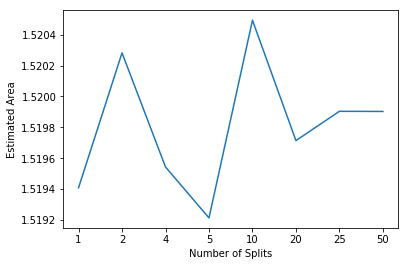

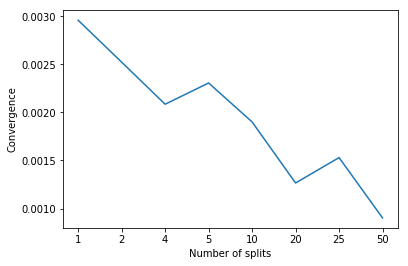

In [61]:
ortho_means = np.zeros((len(splits)))
ortho_convergence = np.zeros((len(splits)))

for i in range(0, len(splits)): 
    ortho_means[i] = np.mean(ortho_estimates[:, i])
    ortho_convergence[i] = 2 * 1.9842 * np.std(ortho_estimates[:, i], ddof=1) / np.sqrt(R)

plt.plot(range(1, len(splits)+1), ortho_means)
plt.ylabel('Estimated Area')
plt.xlabel('Number of Splits')
plt.xticks(range(1, len(splits)+1), splits)
plt.show()

plt.plot(range(1, len(splits)+1), ortho_convergence)
plt.ylabel('Convergence')
plt.xlabel('Number of splits')
plt.xticks(range(1, len(splits)+1), splits)
#plt.yscale('log')
plt.show()

## Testing Normality
Here we try to test and visualize whether the estimated areas from the different runs are actually normally distributed as implied by the central limit theorem. 

In [81]:
R = 1000
S = 100000
MAXITER = 300
estimations = np.zeros((R))
for r in tqdm(range(0, R)): 
    estimations[r] = random_hit_miss(S, MAXITER, xmin, xmax, ymin, ymax)
    #estimations[r] = LHS_hit_miss(S, MAXITER, xmin, xmax, ymin, ymax)
    #estimations[r] = ortho_hit_miss(S, MAXITER, xmin, xmax, ymin, ymax, 20)

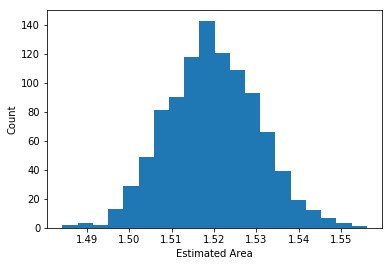

In [82]:
plt.hist(estimations, bins=20, align= 'mid')
plt.xlabel('Estimated Area')
plt.ylabel('Count')
plt.show()

In [83]:
stats.shapiro(estimations)

(0.9989265203475952, 0.8329625129699707)

## Improving Orthogonal Sampling
Here we test a method that might improve the convergence of orthogonal sampling when estimating the area of the Mandelbrot set. Before starting the hit-and-miss algorithm we determine which subcells are completely part of the Mandelbrot set or diverge very quickly. Knowing this, several subcells need not be included in the hit-and-miss algorithm, requiring less darts in total to make a similar estimation as in the normal orthogonal sampling method.

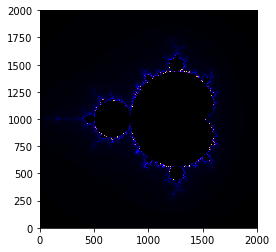

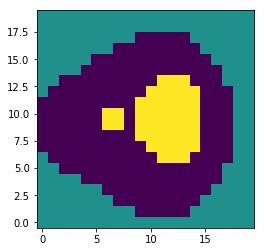

In [110]:
S = 2000
splits = 20
MAXITER = 300
mandelbrot_set = np.zeros((S, S))
cell_range = S / splits

for i in tqdm(range(0, splits)):  #loop over all subcells
    for j in range(0, splits):
        for x in range(int(i*cell_range), int((i+1)*cell_range)):  #loop over all values in this subcell
            for y in range(int(j*cell_range), int((j+1)*cell_range)):
                xc = xmin + x/S * abs(xmin-xmax)
                yc = ymin + y/S * abs(ymin-ymax)
                c = xc +1j*yc
                mandelbrot_set[x, y] = mandelbrot(c, MAXITER)
                
cells = np.zeros((splits, splits))

for i in tqdm(range(0, splits)):  #loop over all subcells
    for j in range(0, splits):
        value = 2
        for x in range(int(i*cell_range), int((i+1)*cell_range)):  #loop over all values in this subcell
            for y in range(int(j*cell_range), int((j+1)*cell_range)):
                if(mandelbrot_set[x,y] > 2): 
                    value = 0 
                elif(mandelbrot_set[x,y] != 0): 
                    value = 1
        cells[i, j] = value

#Plot of the Mandelbrot set
plt.imshow(mandelbrot_set.T, cmap='gnuplot2', origin='lower')
plt.show()

#Coloring of cells to be excluded. 
#Yellow is the Mandelbrot set
#Blue diverges in 1 or 2 iterations
#Purple is diverse, hence will be actually sampled when doing hit-and-miss
plt.imshow(cells.T, origin='lower')
plt.show()

In [119]:
@jit
def improved_ortho_hit_miss(S, MAXITER, xmin, xmax, ymin, ymax, splits, cells):
    """
    Improvement on the original orthogonal sampling method.
    """
    
    if(S % splits**2 != 0): 
        print("Please make sure S is divisible by splits^2.")
        return 0
    
    xsamples = np.arange(1, S+1)  #keeps track of all columns that have been chosen
    ysamples = np.arange(1, S+1)  #keeps track of all rows that have been chosen
    true_samples = np.zeros((S))  #to be filled with the final sampling
    cell_range = S / splits  #the amount of rows (or columns) in a subcells
    for i in range(0, splits):  #loop over all subcells
        for j in range(0, splits):
            inside = False
            if(cells[i,j]==1):
                continue
            if(cells[i,j]==2):
                inside = True
        
            xcandidates = []
            ycandidates = []
            #Copy the columns and rows that have not been picked yet in this cell to be candidates
            for x in range(int(i*cell_range), int((i+1)*cell_range)): 
                if xsamples[x] != 0: 
                    xcandidates.append(xsamples[x])
            for y in range(int(j*cell_range), int((j+1)*cell_range)): 
                if ysamples[y] != 0: 
                    ycandidates.append(ysamples[y])  
            #Shuffle the candidates
            random.shuffle(xcandidates)
            random.shuffle(ycandidates)
            #Pick the first S/splits^2 columns and rows to construct the sampling for this cell
            for s in range(0, int(S/(splits*splits))):                     
                x = xcandidates[s] - 1
                y = ycandidates[s] - 1
                if inside == True: 
                    true_samples[x] = 1
                else: 
                    true_samples[x] = y
                xsamples[x] = 0  #And note down which rows and columns have been picked
                ysamples[y] = 0
    
    #Perform the actual hit-and-miss algorithm with the constructed sampling
    hits = 0
    for s in range(0, S): 
        if(true_samples[s] == 1): 
            hits += 1
        if(true_samples[s] == 0): 
            continue
        x = xmin + s/S * abs(xmin-xmax)
        y = ymin + true_samples[s]/S * abs(ymin-ymax)
        c = x + 1j*y
        if(mandelbrot(c, MAXITER) == 0): 
            hits += 1
    estimated_area = (hits / S) * (abs(xmin - xmax) * abs(ymin - ymax))
    return estimated_area

In [121]:
S = 100000
MAXITER = 300
splits = 20
print(improved_ortho_hit_miss(S, MAXITER, xmin, xmax, ymin, ymax, splits, cells))
actual_shots = S - S/splits**2*(np.sum(cells==1)+np.sum(cells==2))
print("Actual shots taken: %d" % actual_shots)

1.5235200000000002
Actual shots taken: 45750


In [123]:
R = 5  #Number of runs
MAXITER = 300  #Number of iterations in Mandelbrot sequence
S = [] #Number of shots taken
maxp = 6
for p in range(4,maxp+1):
    S.append(10**p)
    if(p < maxp): 
        S.append(2*10**p)
        S.append(5*10**p)
SPLITS = 20  #Splits^2 is the number of subcells in orthogonal sampling
xmin, xmax, ymin, ymax = -2, 1, -1.5, 1.5
ortho_estimates = np.zeros((R, len(S)))
better_ortho_estimates = np.zeros((R, len(S)))
s_index = 0
for s in tqdm(S): 
    for r in range(0, R): 
        ortho_estimates[r, s_index] = ortho_hit_miss(s, MAXITER, xmin, xmax, ymin, ymax, SPLITS)
        better_ortho_estimates[r, s_index] = improved_ortho_hit_miss(s, MAXITER, xmin, xmax, ymin, ymax, SPLITS, cells)
    s_index += 1
    
actual_shots = np.zeros((len(S)))
s_index = 0
for s in S: 
    actual_shots[s_index] = s - s/splits**2*(np.sum(cells==1)+np.sum(cells==2))
    s_index += 1

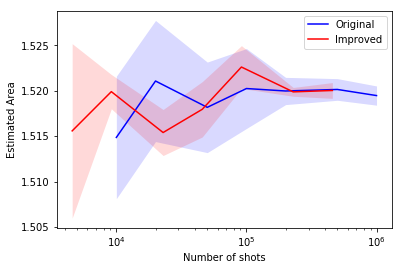

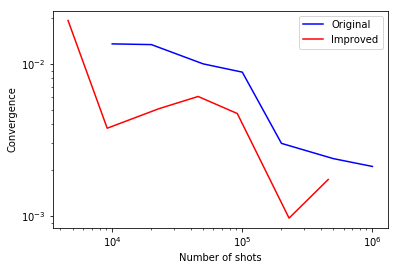

In [124]:
ortho_means = np.zeros((len(S)))
better_ortho_means = np.zeros((len(S)))
ortho_convergence = np.zeros((len(S)))
better_ortho_convergence = np.zeros((len(S)))

for s in range(0, len(S)): 
    ortho_means[s] = np.mean(ortho_estimates[:, s])
    better_ortho_means[s] = np.mean(better_ortho_estimates[:, s])
    ortho_convergence[s] = 2 * 1.9842 * np.std(ortho_estimates[:, s], ddof=1) / np.sqrt(R)
    better_ortho_convergence[s] = 2 * 1.9842 * np.std(better_ortho_estimates[:, s], ddof=1) / np.sqrt(R)

colors = ['blue', 'red']
plt.plot(S, ortho_means, color=colors[0], label='Original')
plt.plot(actual_shots, better_ortho_means, color=colors[1], label='Improved')
plt.fill_between(S, ortho_means-1/2*ortho_convergence, ortho_means+1/2*ortho_convergence, color=colors[0], alpha=0.15, linewidth=0)
plt.fill_between(actual_shots, better_ortho_means-1/2*better_ortho_convergence, better_ortho_means+1/2*better_ortho_convergence, color=colors[1], alpha=0.15, linewidth=0)
plt.ylabel('Estimated Area')
plt.xlabel('Number of shots')
plt.xscale('log')
plt.legend()
plt.show()

plt.plot(S, ortho_convergence, color=colors[0], label='Original')
plt.plot(actual_shots, better_ortho_convergence, color=colors[1], label='Improved')
plt.ylabel('Convergence')
plt.xlabel('Number of shots')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()